# Local fixed point algorithm

## Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import scipy
import itertools
import seaborn as sns
import os
import itertools

import importlib.util
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la

from sklearn.datasets import load_svmlight_file
from helpers import get_solution, read_logs_local_fixed_point, \
run_local_fixed_point_method_single_experiment, run_local_fixed_point_method
from np_functions import logreg_loss as single_point_loss

sns.set(style="whitegrid", context="talk", font_scale=1.2)
%load_ext autoreload
%autoreload 2

## Setting the experiment parameters and generating data

### Specify everything in config.py and then go below

Note: if you are running experiments on a laptop, it's better to use small number of workers

In [2]:
!cat config.py

datasets_path = '/home/gasanoe/datasets'
scripts_path = '/home/gasanoe/Federated-fixed-point-method/code'
plots_path = '{}/../plots'.format(scripts_path)
dataset = 'a9a'
plot_convergence = False
time_tracking = True
n_workers = 20
l1_penalties = {'mushrooms': 1e-2, 'a5a': 1e-8, 'a8a': 1e-8, 'a9a': 2e-6, 'criteo': 4e-12, 'kdd10': 1e-11, 'kdd12': 1e-16, 'url': 1e-8, 'rcv1': 3e-6}
big_regularization = True
logs_path = '{0}/fixed_point/raw_data_{1}'.format(plots_path, dataset)
use_local_data = True
permute_data = False


In [3]:
!python generate_data.py

Number of data points: 32561
Creating chunk number 1
Creating chunk number 2
Creating chunk number 3
Creating chunk number 4
Creating chunk number 5
Creating chunk number 6
Creating chunk number 7
Creating chunk number 8
Creating chunk number 9
Creating chunk number 10
Creating chunk number 11
Creating chunk number 12
Creating chunk number 13
Creating chunk number 14
Creating chunk number 15
Creating chunk number 16
Creating chunk number 17
Creating chunk number 18
Creating chunk number 19
Creating chunk number 20


In [3]:
import config
from config import datasets_path, scripts_path, dataset, n_workers, big_regularization, scripts_path, logs_path, use_local_data

data_path = '{}/data'.format(scripts_path)
zero_based = {'mushrooms': False}

data = load_svmlight_file('{}/{}'.format(datasets_path, dataset), zero_based=zero_based.get(dataset, 'auto'))
l1 = 0 # We don't care about prox
X, y = data[0].toarray(), data[1]
if 2 in y:
    y[y == 2] = -1
n, d = X.shape
L = 0.25 * np.max(np.sum(np.square(X), axis=1))
data_info = np.load('{}/data/data_info.npy'.format(scripts_path))
Ls = data_info[4:]
l2 = np.mean(Ls) / n

Helper functions

In [4]:
def smooth_array(x, k=2, average=True, skip_first=0):
    if skip_first != 0:
        smoothed_part = smooth_array(x[skip_first:], k=k, average=average, skip_first=0)
        return np.array(list(x[:skip_first]) + list(smoothed_part))
    xs = [np.roll(x, i) for i in range(k)]
    for i in range(k):
        xs[i][0] = x[0]
    if average:
        return np.mean(xs, axis=0)
    return np.prod(xs, axis=0) ** (1 / k)

def logreg_loss(w, X, y, l2):
    assert l2 >= 0
    assert len(y) == X.shape[0]
    assert len(w) == X.shape[1]
    l = np.log(1 + np.exp(-X.dot(w) * y))
    m = y.shape[0]
    return np.sum(l) / m + l2/2 * la.norm(w) ** 2

def r(x, l1):
    return l1 * la.norm(x, ord = 1)

def F(w, X, y, l2, l1=0):
    assert ((y.shape[0] == X.shape[0]) & (w.shape[0] == X.shape[1]))
    assert ((l2 >= 0) & (l1 >= 0))
    return logreg_loss(w, X, y, l2) + r(w, l1)

markers = [',', 'o', '*', 'x', 'd', 'D']
mv = 20

## Finding the optimal solution by vanilla SVRG

Computing the solution using SVRG
################################################################################

0.3246133211815469

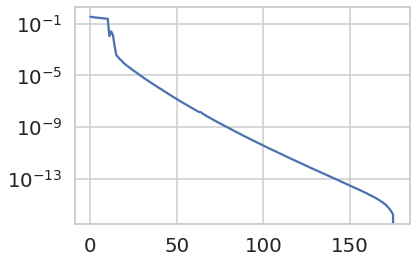

In [5]:
w_star, ws_star = get_solution(X, y, L, l2=l2, data_path=data_path, dataset=dataset, S=80,
                               big_regularization=big_regularization, recompute=True)
losses_svrg = [F(w, X, y, l2=l2, l1=l1) for w in ws_star]
plt.plot(losses_svrg - np.min(losses_svrg))
plt.yscale('log')
f_min = F(w_star, X, y, l2=l2, l1=l1)
f_min

## Computational experiments

#### Varying number of local steps

In [14]:
it_max = 200000
t_max = 0
lr0 = 1.0
operator = 'full'
alpha = 0.5
n_locals = [1, 2, 4, 8, 16, 32]

In [15]:
for n_local in n_locals:
    run_local_fixed_point_method_single_experiment(n_workers, scripts_path, it_max, t_max, lr0, operator, \
                                                   alpha, n_local)

######

In [16]:
SMALL_SIZE = 8
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [17]:
markers = ["*", "8", "X", "D", "o", "v"]

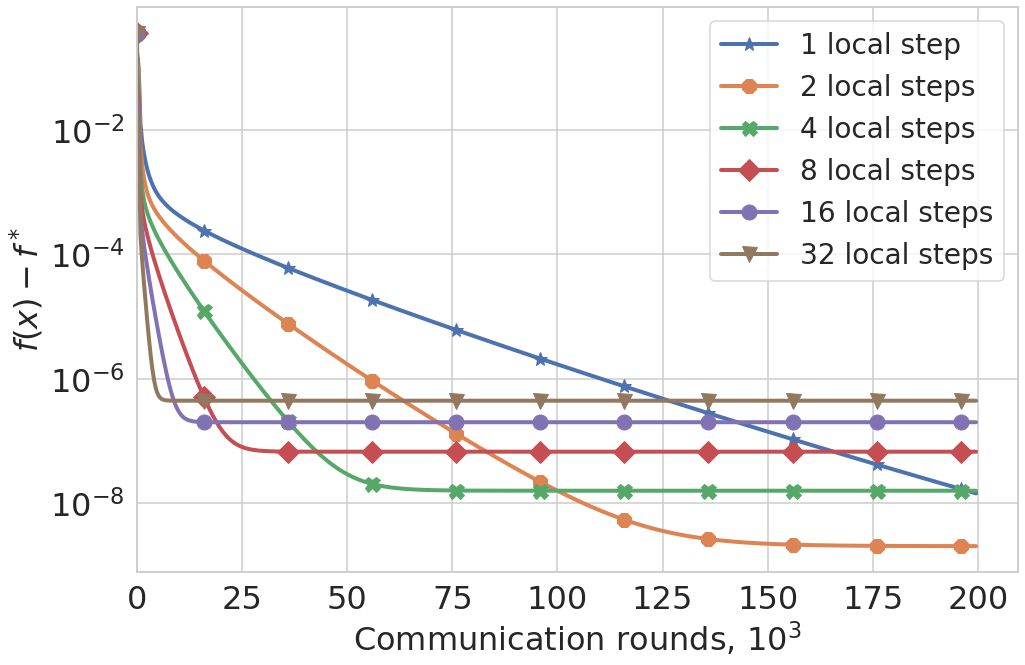

In [24]:
plt.figure(figsize=(15, 10))
count = 0
for n_local in n_locals:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path)
    label = '1 local step' if n_local == 1 else '{} local steps'.format(n_local)
    idx = its < 200000
    xlabels = its[idx] / 1000
    plt.plot(xlabels, smooth_array(loss[idx]) - f_min, label=label, linewidth=4.0, marker=markers[count], \
            markevery = 49, markersize = 15)
    count += 1
#     plt.plot(its, smooth_array(loss) - f_min, label=label, linewidth=2.0)

plt.yscale('log')
plt.xlabel('Communication rounds, $10^3$')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
# plt.gca().set_xtick(range(len(idx)))
# plt.xticks([25, 50, 75, 100, 125, 150, 175, 200])
# matplotlib.axes.Axes.set_xscale(10, 'linear')
plt.legend()
plt.tight_layout()
plt.savefig('{}/local_steps.pdf'.format(config.plots_path), dpi=300)

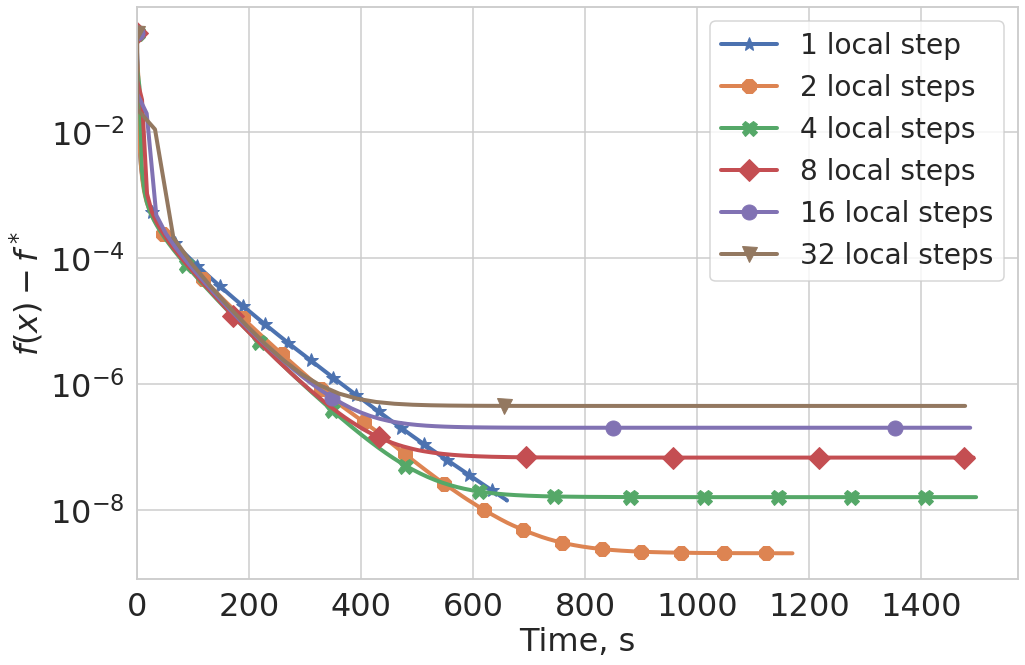

In [25]:
plt.figure(figsize=(15, 10))
count = 0
for n_local in n_locals:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path)
    label = '1 local step' if n_local == 1 else '{} local steps'.format(n_local)
#     idx = ts < 1500
#     plt.plot(ts[idx], smooth_array(loss[idx]) - f_min, label=label, linewidth=4.0, marker=markers[count], \
#             markevery = 30, markersize = 15)
    
    count += 1
plt.yscale('log')
plt.xlabel('Time, s')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('{}/local_steps_in_time.pdf'.format(config.plots_path), dpi=300)

#### Varying alpha

In [7]:
it_max = 80000
t_max = 0
lr0 = 1.0
operator = 'full'
alphas = [0.4, 0.6, 0.8, 1.0]
n_local = 8

In [77]:
for alpha in alphas:
    run_local_fixed_point_method_single_experiment(n_workers, scripts_path, it_max, t_max, lr0, operator, \
                                                   alpha, n_local)

#####

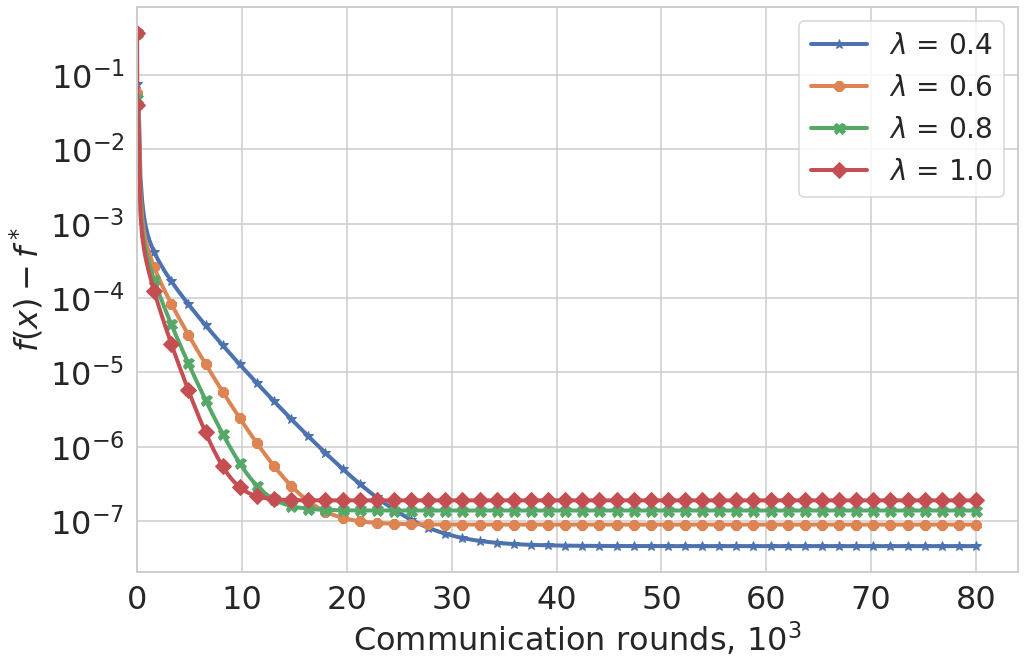

In [11]:
plt.figure(figsize=(15, 10))
count = 0
for alpha in alphas:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path)
    label = "$\lambda$ = {}".format(alpha)
    xlabels = its/ 1000
    plt.plot(xlabels, smooth_array(loss) - f_min, label=label, linewidth=4.0, marker=markers[count],
             markevery = 10, markersize = 11)
    count += 1

plt.yscale('log')
plt.xlabel('Communication rounds, $10^3$')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('{}/alphas.pdf'.format(config.plots_path), dpi=300)

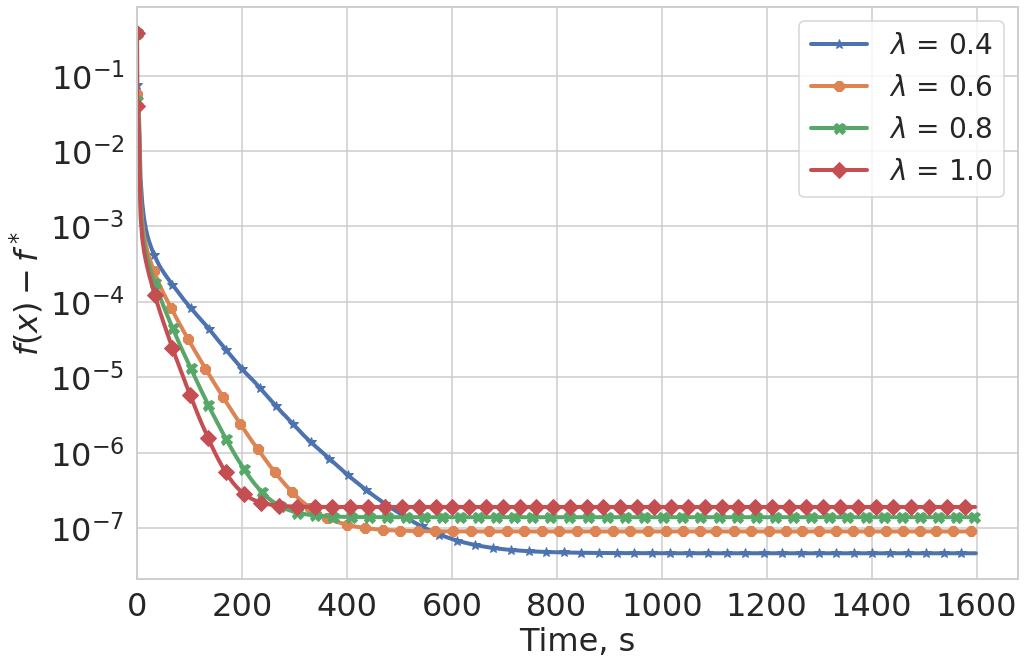

In [12]:
plt.figure(figsize=(15, 10))
count = 0
for alpha in alphas:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path)
    label = "$\lambda$ = {}".format(alpha)
    idx = ts < 1600
    plt.plot(ts[idx], smooth_array(loss[idx]) - f_min, label=label, linewidth=4.0, marker=markers[count],
             markevery = 10, markersize = 11)
    count += 1
plt.yscale('log')
plt.xlabel('Time, s')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.xlim(0,)
plt.tight_layout()
plt.savefig('{}/alphas_in_time.pdf'.format(config.plots_path), dpi=300)

Varying probabilites

In [26]:
it_max = 50000
t_max = 0
lr0 = 1.0
probs = [0.05, 0.1, 0.2, 0.4, 0.8]
operator = 'full'
alpha = 0.5
n_local = 4

In [27]:
for prob in probs:
    run_local_fixed_point_method_single_experiment(n_workers, scripts_path, it_max, t_max, lr0, operator, \
                                                   alpha, n_local, True, prob)    

#####

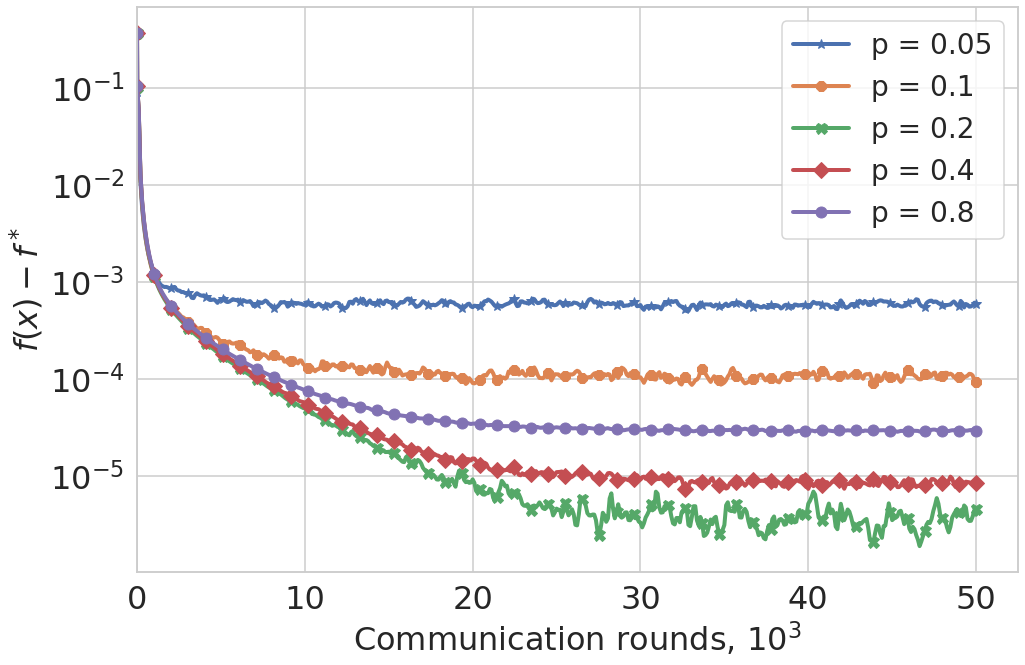

In [28]:
plt.figure(figsize=(15, 10))
count = 0
for prob in probs:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path, True, prob)
    label = "p = {}".format(prob)
    xlabels = its / 1000
    plt.plot(xlabels, smooth_array(loss) - f_min, label=label, linewidth = 4.0, marker=markers[count],
             markevery = 10, markersize = 11)
    count += 1
plt.yscale('log')
plt.xlabel('Communication rounds, $10^3$')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('{}/probs_alpa_is_constant.pdf'.format(config.plots_path), dpi=300)

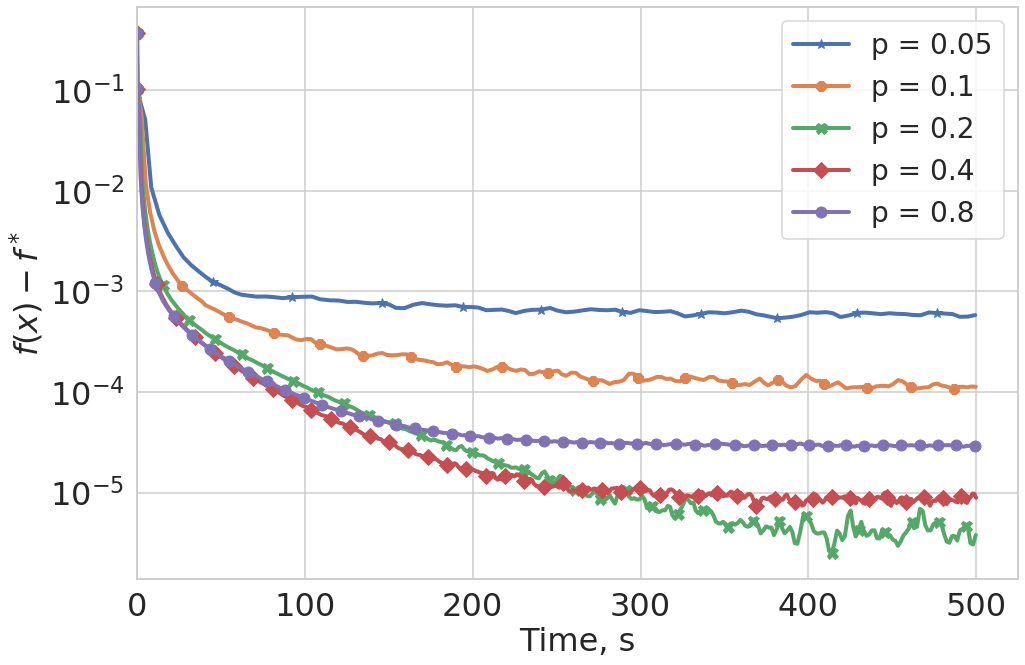

In [31]:
plt.figure(figsize=(15, 10))
count = 0
for prob in probs:
    ws, loss, its, ts = read_logs_local_fixed_point(alpha, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path, True, prob)
    label = "p = {}".format(prob)
    idx = ts < 500
    plt.plot(ts[idx], smooth_array(loss[idx]) - f_min, label=label, linewidth = 4.0, marker=markers[count],
             markevery = 10, markersize = 11)
#     plt.plot(ts, smooth_array(loss) - f_min, label=label, linewidth = 4.0, marker=markers[count],
#              markevery = 10, markersize = 11)

    count += 1
plt.yscale('log')
plt.xlabel('Time, s')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('{}/probs_in_time_alpa_is_constant.pdf'.format(config.plots_path), dpi=300)

In [8]:
it_max = 50000
t_max = 0
lr0 = 1.0
probs = [0.05, 0.1, 0.2, 0.4, 0.8]
operator = 'full'

n_local = 4

In [9]:
for prob in probs:
    run_local_fixed_point_method_single_experiment(n_workers, scripts_path, it_max, t_max, lr0, operator, \
                                                   prob, n_local, True, prob)  

#####

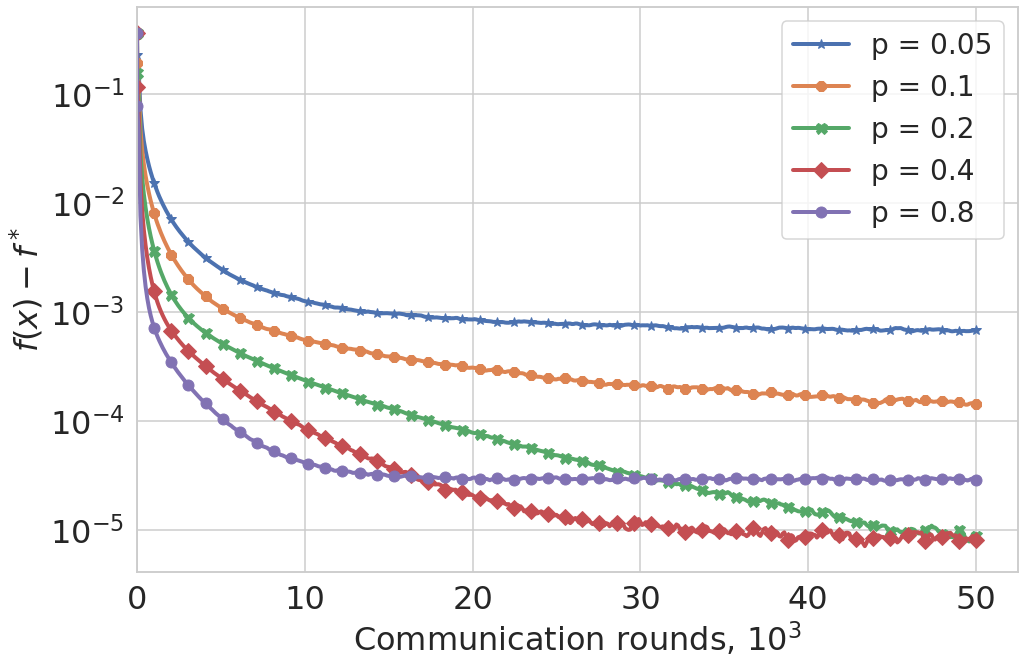

In [11]:
plt.figure(figsize=(15, 10))
count = 0
for prob in probs:
    ws, loss, its, ts = read_logs_local_fixed_point(prob, n_local, n_workers, dataset, operator, \
    big_regularization, use_local_data, logs_path, True, prob)
    label = "p = {}".format(prob)
    xlabels = its / 1000
    plt.plot(xlabels, smooth_array(loss) - f_min, label=label, linewidth=4.0, marker=markers[count],
             markevery = 10, markersize = 11)
    count += 1
plt.yscale('log')
plt.xlabel('Communication rounds, $10^3$')
plt.ylabel('$f(x) - f^*$')
plt.xlim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('{}/probs_alpa_is_equal_to_p.pdf'.format(config.plots_path), dpi=300)